<h1>Data Preparation<h1>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import time
# import cv2
import imageio.v2 as imageio
import torch
import torchvision
from torchvision import utils as vutils
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torch.optim import SGD, Adam
from PIL import Image
import matplotlib.pyplot as plt
import os
import zipfile
from statistics import mean


In [ ]:
# Specify the path to the zip file
zip_file_path = '../content/drive/MyDrive/archive 2.zip'

# Specify the directory where you want to extract the contents
extracted_dir = './training_data'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extracted_dir)

print(f"Contents of {zip_file_path} have been extracted to {extracted_dir}")

Contents of ../content/drive/MyDrive/archive 2.zip have been extracted to ./training_data


<h2>Global Variables<h2>

In [ ]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Experiments running on: {}'.format(device))
# Hyperparameters
random_seed = 1
learning_rate = 0.01
num_epochs = 50

# Architecture

root_dir = 'data'



Experiments running on: cpu


In [ ]:
'''
Extract number of positive vs negative samples (where negative samples have an all-zero mask)
Check for files without corresponding mask and vice versa
'''
root = './training_data/archive/lgg-mri-segmentation/kaggle_3m'

no_mask = 0
no_mask_files = []
no_file = 0
no_files = []
num_empty_masks = 0
num_nonempty_masks = 0

S = 3 # number of pos/neg samples to take
empty_mask_samples = []
nonempty_mask_samples = []

img_dimensions = []
msk_dimensions = []

n_files = 0
for directory in [os.path.join(root,x) for x in os.listdir(root) if os.path.isdir(os.path.join(root, x))]:
    for file in os.listdir(directory):
        if not file.endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff')):
            continue  # Skip non-image files
        n_files += 1
        img_dimensions.append(np.array(imageio.imread(os.path.join(directory, file), format='tif')).shape)
        #count files with no mask
        if 'mask' not in file:
            #check if mask exists
            mask_path = os.path.join(directory, file[:file.find('.tif')]+'_mask.tif')
            if not os.path.exists(mask_path):
                no_mask += 1
                no_mask_files.append(os.path.join(directory, file))
        else:
            msk_dimensions.append(np.array(imageio.imread(os.path.join(directory, file), format='tif')).shape)
            #count masks with no file
            f_path = os.path.join(directory, file[:file.find('mask')-1]+'.tif')
            #check if file exists
            if not os.path.exists(f_path):
                no_file += 1
                no_files.append(os.path.join(directory, file))

            #check if mask is empty
            j = np.max(imageio.imread(os.path.join(directory, file), format='tif'))
            if j > 0:
                num_nonempty_masks += 1
                if len(nonempty_mask_samples) < S:
                    nonempty_mask_samples.append(os.path.join(directory, file))
            else:
                num_empty_masks += 1
                if len(empty_mask_samples) < S:
                    empty_mask_samples.append(os.path.join(directory, file))

In [ ]:

!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
#check variance in dimensions
print('Image Dimensions')
print(len(set(img_dimensions)))
print(set(img_dimensions))
print('Mask Dimensions')
print(len(set(msk_dimensions)))
print(set(msk_dimensions))

Image Dimensions
2
{(256, 256), (256, 256, 3)}
Mask Dimensions
1
{(256, 256)}


#No Mask: 0
#Mask w/ No File: 0
#Total Files 7858


<BarContainer object of 2 artists>

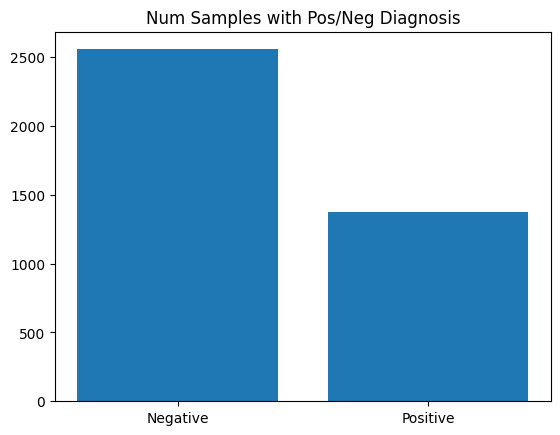

In [ ]:
print(f'#No Mask: {no_mask}')
print(f'#Mask w/ No File: {no_file}')
print(f'#Total Files {n_files}')

plt.figure()
plt.title('Num Samples with Pos/Neg Diagnosis')
plt.bar([0,1], [num_empty_masks, num_nonempty_masks], tick_label=['Negative', 'Positive'])

Luckily no files are missing their counterpart either, as some files have a completely negative diagnoses it may be a problem to train our segmentation model on an unbalanced dataset like this. A few approaches can be taken to deal with this:

1. We balance our sampling during training time to avoid biasing the segmentation algorithm, this could still be faulty
2. We employ a classifier to make a diagnoses (positive/negative) and only segment positive diagnoses

In this notebook we will assume the use of the second approach - sometimes practitioners will make this classifier another output layer of the segmenter so that they can share important features, other times we make use of transfer learning and train something like ResNet50 in order to create a robust classifier to support the segmenter. Here we out goal is mainly to increase the quality of the segmentation, so we will just train the segmenter on only positive samples.

Since we only need the positive files for training we will forget about the negative files

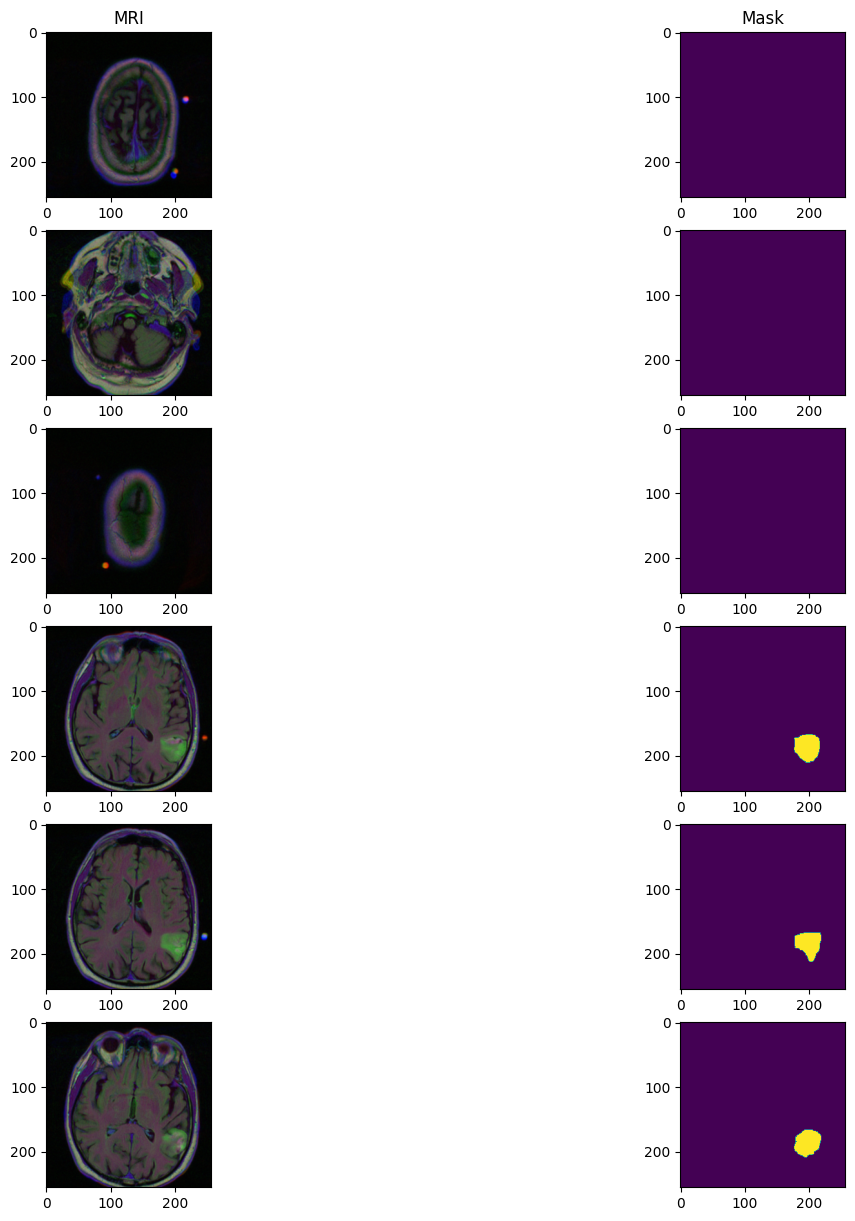

In [ ]:
#display images of negative and positive samples - negative samples have an empty mask
fig, axs = plt.subplots(6,2, figsize=(15,15))
for ax, col in zip(axs[0], ['MRI', 'Mask']):
    ax.set_title(col)

display_imgs = empty_mask_samples+nonempty_mask_samples #concat lists for easy plotting
#print(display_imgs)
for i in range(len(display_imgs)):
    mask_path = display_imgs[i]
    img_path = mask_path[:mask_path.find('mask')-1]+'.tif'
    axs[i,0].imshow(np.array(imageio.imread(img_path)))
    axs[i,1].imshow(np.array(imageio.imread(mask_path)))

<h1>Create Torch Dataset<h1>

Classification

In [ ]:
class Brain_MRI_Classification_Dataset(data.Dataset):
    def __init__(self, inputs, transform=None):
        self.inputs = inputs
        self.transform = transform
        self.input_dtype = torch.float32
        self.target_dtype = torch.float32

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        #for classification return only the image and the binary label
        img_path = self.inputs[index][0]
        image = imageio.imread(img_path)
        x = torch.from_numpy(np.transpose(np.array(image), (2,0,1))).type(self.input_dtype)
        y = torch.from_numpy(np.array(self.inputs[index][2])).type(self.target_dtype)

        if self.transform is not None:
            x = self.transform(x)

        return x,y



Segementation

In [ ]:
class Brain_MRI_Segmentation_Dataset(data.Dataset):
    def __init__(self, inputs, transform=None):
        self.inputs = inputs
        self.transform = transform
        self.input_dtype = torch.float32
        self.target_dtype = torch.float32

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        #for classification return only the image and the binary label
        img_path = self.inputs[index][0]
        mask_path = self.inputs[index][1]
        #mask_img = cv2.normalize(cv2.imread(mask_path), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        mask_img = imageio.imread(mask_path)
        x = torch.from_numpy(np.transpose(np.array(imageio.imread(img_path)), (2,0,1))).type(self.input_dtype)
        y = torch.from_numpy(np.resize(np.array(mask_img)/255., (1,256,256))).type(self.target_dtype)

        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)

        return x,y

In [ ]:
#store list of train files for dataset creation of the form (train_img, mask_img, pos_neg_result(1/0))
#these tuples are fed into the datasets we create below
file_list = []
for directory in [os.path.join(root,x) for x in os.listdir(root) if os.path.isdir(os.path.join(root, x))]:
    for file in os.listdir(directory):
        #add files to list
        if 'mask' not in file:
            result = 0
            img_path = os.path.join(directory, file)
            mask_path = os.path.join(directory, file[:file.find('.tif')]+'_mask.tif')

            #check if mask is nonempty
            # Check if the mask file exists
            if os.path.exists(mask_path) and np.max(imageio.imread(mask_path)) > 0:
                result = 1

            file_list.append([img_path, mask_path, result])


In [ ]:
#load data
positive_diagnoses = [x for x in file_list if x[2] == 1]
print(positive_diagnoses[:5])
print(len(positive_diagnoses))

[['./training_data/archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_13.tif', './training_data/archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_13_mask.tif', 1], ['./training_data/archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_14.tif', './training_data/archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_14_mask.tif', 1], ['./training_data/archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_12.tif', './training_data/archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_12_mask.tif', 1], ['./training_data/archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_17.tif', './training_data/archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_17_mask.tif', 1], ['./training_data/archive/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_

In [ ]:


mri_dataset = Brain_MRI_Segmentation_Dataset(positive_diagnoses)

validation_size = int(0.2 * len(mri_dataset))
test_size = int(0.1 * len(mri_dataset))

train_set, val_set, test_set = data.random_split(mri_dataset, [len(mri_dataset)-(validation_size+test_size), validation_size, test_size])

train_loader = data.DataLoader(dataset=train_set, batch_size=2, shuffle=True, num_workers=2)
val_loader = data.DataLoader(dataset=val_set, batch_size=2, shuffle=False, num_workers=2)
test_loader = data.DataLoader(dataset=test_set, batch_size=2, shuffle=False, num_workers=2)


<h3>Losses<h3>

Dice Loss

In [ ]:
#Dice Loss Function - taken from: https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py
def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1, device=device)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)


In [ ]:
#combined cross entropy and dice loss
def bce_dice_loss(output, target):
    bce = nn.BCEWithLogitsLoss()
    return bce(output, target) + dice_loss(output, target)


In [ ]:
#Cross entropy loss used in class
def Cross_loss(output, target):
    loss_func = torch.nn.CrossEntropyLoss()
    return loss_func(output, target)


**IoU Metric**
Obtained from: https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    SMOOTH = 1e-6
    # outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    # labels = labels.squeeze(1)

    bin_out = torch.where(outputs > threshold, 1, 0).type(torch.int16)
    labels = labels.type(torch.int16)

    intersection = (bin_out & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (bin_out | labels).float().sum((1, 2))         # Will be zero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our division to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch


<h1>Models<h1>

Segnet

In [ ]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.sequence(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(Decoder, self).__init__()
        combined_channels = in_channels + skip_channels
        self.sequence = nn.Sequential(
            nn.Conv2d(combined_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.sequence(x)

class Segnet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Segnet, self).__init__()

        # Reduced Encoder Layers
        self.encoder1 = Encoder(in_channels, 64)
        self.encoder2 = Encoder(64, 128)
        self.encoder3 = Encoder(128, 256)

        # Reduced Decoder Layers
        self.decoder1 = Decoder(256, 0, 128)
        self.decoder2 = Decoder(128, 128, 64)
        self.decoder3 = Decoder(64, 64, out_channels)   # Changed the final decoder layer

        # Final Output Convolution
        self.output_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)

        # Decoding
        d1 = self.decoder1(e3)
        d2 = self.decoder2(torch.cat([d1, e2], dim=1))
        d3 = self.decoder3(torch.cat([d2, e1], dim=1))

        # Output
        logits = self.output_conv(d3)

        return logits


In [ ]:
modelSegnet = Segnet(in_channels=3, out_channels=1)


In [ ]:
torch.cuda.empty_cache()
modelSegnet.to(device)
# print(modelSegnet)


Segnet(
  (encoder1): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (encoder2): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
       

In [ ]:
num_params = sum(p.numel() for p in modelSegnet.parameters() if p.requires_grad)
print(num_params)

1857430


<h3>DeepLabV2<h3>

In [ ]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.aspp1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.aspp2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6, bias=False)
        self.aspp3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12, bias=False)
        self.aspp4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18, bias=False)
        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                             nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                                             nn.Upsample(size=(in_channels, in_channels), mode='bilinear', align_corners=True))

    def forward(self, x):
        x1 = self.aspp1(x)
        # print(f"x1 shape: {x1.shape}")
        x2 = self.aspp2(x)
        # print(f"x2 shape: {x2.shape}")
        x3 = self.aspp3(x)
        # print(f"x3 shape: {x3.shape}")
        x4 = self.aspp4(x)
        # print(f"x4 shape: {x4.shape}")
        x5 = self.global_avg_pool(x)
        # print(f"x5 shape: {x5.shape}")

        # Upsample x5 to match the size of x1, x2, x3, and x4
        target_size = x1.size()[2:]  # Extract the height and width from x1
        x5 = F.interpolate(x5, size=target_size, mode='bilinear', align_corners=True)

        return torch.cat([x1, x2, x3, x4, x5], dim=1)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), # corrected here
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)



class Encoder(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(Encoder, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, mid_channels),
            ASPP(mid_channels, mid_channels),
            nn.Conv2d(mid_channels * 5, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
        )

    def forward(self, x):
        return self.sequence(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, output_size=(256, 256)):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.aspp = ASPP(in_channels, mid_channels)
        self.conv1x1 = nn.Conv2d(mid_channels * 5, out_channels, kernel_size=1, stride=1, padding=0, bias=False)

        self.encoder = Encoder(in_channels, mid_channels, out_channels)
        self.upsample = nn.Upsample(size=self.output_size, mode='bilinear', align_corners=False)

        self.final_conv = nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        x_aspp = self.aspp(x)
        x1 = self.conv1x1(x_aspp)
        x1 = self.upsample(x1)

        x2 = self.encoder(x)
        x2 = self.upsample(x2)

        # Check and adjust the sizes if they do not match
        # if x1.size()[2:] != x2.size()[2:]:
            # Adjust x1 or x2 using additional upsampling or downsampling
            # For example:
            # x1 = F.interpolate(x1, size=x2.size()[2:], mode='bilinear', align_corners=False)

        x_concat = torch.cat([x1, x2], dim=1)
        x_final = self.final_conv(x_concat)
        return x_final


class Deeplab(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(Deeplab, self).__init__()

        # Make sure that the channel sizes are consistent
        self.encoder = Encoder(in_channels, mid_channels, mid_channels)

        # The decoder receives the output from the encoder
        self.decoder = Decoder(mid_channels, mid_channels, out_channels)

    def forward(self, x):
        # Encoder and decoder operations
        x = self.encoder(x)
        x = self.decoder(x)

        return x





In [ ]:
modelDeeplab = Deeplab(3,128, 1)

In [ ]:
modelDeeplab.to(device)

Deeplab(
  (encoder): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): ReLU(inplace=True)
          (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (7): ReLU(inplace=True)
        )
      )
      (1): ASPP(
        (aspp1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (aspp2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False)
        (aspp3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation

In [ ]:
num_params = sum(p.numel() for p in modelDeeplab.parameters() if p.requires_grad)
print(num_params)

2249362


<h3>Unet<h3>

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.sequence(x)

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.sequence = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.sequence(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        #input_dim = 256
        self.encoder = nn.ModuleList([
            DownConv(in_channels, 64), #128
            DownConv(64, 128), #64
            DownConv(128, 256), #32
            DownConv(256, 512) #16
        ])

        self.bottleneck = ConvBlock(512, 1024)

        #extra channels allow for concatenation of skip connections in upsampling block
        self.decoder = nn.ModuleList([
            UpConv(512+1024,512), #32
            UpConv(256+512,256), #64
            UpConv(128+256,128), #128
            UpConv(64+128,64) #256
        ])

        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        o = x
        for layer in self.encoder:
            o = layer(o)
            skips.append(o)

        o = self.bottleneck(o)

        for i, layer in enumerate(self.decoder):
            #print(o.size())
            o = torch.cat((skips[len(skips)-i-1],o), dim=1)
            #print(o.size())
            o = layer(o)

        return self.output_conv(o)

In [ ]:
modelUnet = UNet()

In [ ]:
num_params = sum(p.numel() for p in modelUnet.parameters() if p.requires_grad)
print(num_params)

43921473


<h2>Optimizer<h2>

In [ ]:
# optimizer_SGD_Segnet = torch.optim.SGD(modelSegnet.parameters(), lr=learning_rate)
# optimizer_Adam_Segnet = torch.optim.Adam(modelSegnet.parameters(), lr=learning_rate)

<h1>Train/Validation Loop<h1>

In [ ]:

from torch.cuda.amp import GradScaler, autocast

def run_experiment(model_name, model, num_epochs, optimizer, loss_fn, train_loader, val_loader, device='cuda', clear_mem=True, accumulation_steps=1):
    # Initialize the GradScaler
    scaler = GradScaler()

    train_losses = []
    val_losses = []
    val_scores = []
    train_scores = []
    train_acc_lst, valid_acc_lst = [], []
    train_loss_lst, valid_loss_lst = [], []

    best_acc = 0
    start_time = time.time()

    model.to(device)
    print('Model sent to ' + str(device))

    for epoch in range(num_epochs):
        #######################
        # Train model         #
        #######################
        model.train()
        for i, (features, targets) in enumerate(train_loader):
            img = features.to(device)
            msk = targets.to(device)



            # Resets the gradients to zero
            optimizer.zero_grad()

            # Forward pass with autocasting
            # with autocast():
            logits = model(img)

            loss = loss_fn(logits, msk)

            # Scales loss, calls backward() to create scaled gradients
            loss.backward()

            # Unscales the gradients and calls or skips optimizer.step()
            optimizer.step()

            # Updates the scale for next iteration
            # scaler.update()

            iou_score = iou_pytorch(logits.detach(), msk)

            train_losses.append(loss.item())
            train_scores.append(iou_score)

            if i % 50 == 0:
                print(f'Epoch: {epoch+1:05d}/{num_epochs:05d} | Batch {i:05d}/{len(train_loader):05d} | Loss: {loss.item():.4f} | IoU: {iou_score:.4f}')

        #######################
        # Validate model      #
        #######################
        model.eval()
        with torch.no_grad():
            for i, (features, targets) in enumerate(val_loader):
                img = features.to(device)
                msk = targets.to(device)

                # Forward pass without autocasting
                logits = model(img)
                loss = loss_fn(logits, msk)

                iou_score = iou_pytorch(logits.detach(), msk)

                val_losses.append(loss.item())
                val_scores.append(iou_score)

                if i % 50 == 0:
                    print(f'Validation | Epoch: {epoch+1:05d}/{num_epochs:05d} | Batch {i:05d}/{len(val_loader):05d} | Loss: {loss.item():.4f} |IoU: {iou_score:.4f}')



    results = {
        'model_name': model_name,
        'train_losses': train_losses,
        'train_scores': train_scores,
        'val_losses': val_losses,
        'val_scores': val_scores
    }

    if clear_mem:
        del model
        del optimizer
        del loss_fn
        torch.cuda.empty_cache()

    return results


In [ ]:
def test_model(model, test_loader, device, loss_fn):
    model.eval()  # Set the model to evaluation mode
    test_losses = []
    test_scores = []

    with torch.no_grad():  # Disable gradient calculations
        for i, (features, targets) in enumerate(test_loader):
            img, msk = features.to(device), targets.to(device)
            logits = model(img)
            loss = loss_fn(logits, msk)
            test_losses.append(loss.item())
            iou_score = iou_pytorch(logits.detach(), msk)
            test_scores.append(iou_score)

            if i % 50 == 0:
                print(f'Test | Batch {i:05d}/{len(test_loader):05d} | Loss: {loss.item():.4f} |IoU: {iou_score:.4f}')

    return test_losses, test_scores

In [ ]:
def plot_training_scores(losses, train_scores):

    # Convert list to PyTorch tensor or NumPy array
    train_scores_tensor = torch.tensor(train_scores)

    # Convert tensors to CPU if they are on GPU
    if train_scores_tensor.is_cuda:
        train_scores_tensor = train_scores_tensor.cpu()

    # Plot loss and IoU
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title('Train BCE Loss')
    axs[0].plot(range(len(losses)), losses)

    axs[1].set_title('IoU Score vs Training Step')
    axs[1].plot(range(len(train_scores_tensor)), train_scores_tensor.numpy())  # Convert to numpy array here

    print(f'MEAN TRAIN IOU: {torch.mean(train_scores_tensor)}')


def plot_validation_scores(val_losses, val_scores):
    #plot loss and IoU scores - we use a histogram because we care about the distribution of losses, not its progression
    fig, axs = plt.subplots(1,2, figsize=(7,7))
    axs[0].set_title('BCE Loss on Validation Set')
    axs[0].hist(val_losses)

    temp = [t.cpu().item() for t in val_scores]
    axs[1].set_title('IoU Scores on Validation Set')
    axs[1].hist(temp)
    axs[1].axvline(np.median(np.array(temp)), color='k', linestyle='dashed', linewidth=1)
    print(f'MEAN VAL IOU: {mean(temp)}')


def plot_test_scores(test_losses, test_scores):
    # Convert list to PyTorch tensor or NumPy array
    test_scores_tensor = torch.tensor(test_scores)

    # Convert tensors to CPU if they are on GPU
    if test_scores_tensor.is_cuda:
        test_scores_tensor = test_scores_tensor.cpu()

    # Plot loss and IoU
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title('Test BCE Loss')
    axs[0].plot(range(len(test_losses)), test_losses)

    axs[1].set_title('IoU Score vs Test Steps')
    axs[1].plot(range(len(test_scores_tensor)), test_scores_tensor.numpy())  # Convert to numpy array here

    print(f'MEAN TEST IOU: {torch.mean(test_scores_tensor)}')


def visualize_segmentation(model, data_loader, num_samples=5, device='cuda'):
    #visualize segmentation on unseen samples
    fig, axs = plt.subplots(num_samples, 3, figsize=(60,60))

    for ax, col in zip(axs[0], ['MRI', 'Ground Truth', 'Predicted Mask']):
        ax.set_title(col)

    index = 0
    for i,batch in enumerate(data_loader):
            img = batch[0].to(device)
            msk = batch[1].to(device)

            output = model(img)

            for j in range(batch[0].size()[0]):  # iterate over batch size
                img_cpu = img[j].detach().cpu().numpy()  # Convert to numpy array after moving to CPU
                msk_cpu = torch.squeeze(msk[j]).detach().cpu().numpy()
                output_cpu = torch.squeeze(output[j]).detach().cpu().numpy()

                axs[index, 0].imshow(np.transpose(img_cpu, (1, 2, 0)).astype(np.uint8), cmap='bone', interpolation='none')
                axs[index, 1].imshow(np.transpose(img_cpu, (1, 2, 0)).astype(np.uint8), cmap='bone', interpolation='none')
                axs[index, 1].imshow(msk_cpu, cmap='Blues', interpolation='none', alpha=0.5)
                axs[index, 2].imshow(np.transpose(img_cpu, (1, 2, 0)).astype(np.uint8), cmap='bone', interpolation='none')
                axs[index, 2].imshow(output_cpu, cmap='Greens', interpolation='none', alpha=0.5)


                index += 1

            if index >= num_samples:
                break

    plt.tight_layout()


<h2>Experiments<h2>

In [ ]:
torch.cuda.empty_cache()

<h3>Segnet<h3>

In [ ]:
model = modelSegnet
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = dice_loss
train_loader= train_loader
val_loader= val_loader

torch.cuda.empty_cache()
results = run_experiment("Segnet", model, num_epochs, optimizer, loss_fn, train_loader, val_loader, device=device, clear_mem=True)


Model sent to cpu


/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch: 00001/00050 | Batch 00000/00481 | Loss: 0.6023 | IoU: 0.7402
Epoch: 00001/00050 | Batch 00050/00481 | Loss: 0.6050 | IoU: 0.7930
Epoch: 00001/00050 | Batch 00100/00481 | Loss: 0.6018 | IoU: 0.7910
Epoch: 00001/00050 | Batch 00150/00481 | Loss: 0.6018 | IoU: 0.8730
Epoch: 00001/00050 | Batch 00200/00481 | Loss: 0.5823 | IoU: 0.8262
Epoch: 00001/00050 | Batch 00250/00481 | Loss: 0.5942 | IoU: 0.8887
Epoch: 00001/00050 | Batch 00300/00481 | Loss: 0.5508 | IoU: 0.6738
Epoch: 00001/00050 | Batch 00350/00481 | Loss: 0.5663 | IoU: 0.8320
Epoch: 00001/00050 | Batch 00400/00481 | Loss: 0.5757 | IoU: 0.8418
Epoch: 00001/00050 | Batch 00450/00481 | Loss: 0.5573 | IoU: 0.7910
Validation | Epoch: 00001/00050 | Batch 00000/00137 | Loss: 0.5653 |IoU: 0.8301
Validation | Epoch: 00001/00050 | Batch 00050/00137 | Loss: 0.5722 |IoU: 0.8145
Validation | Epoch: 00001/00050 | Batch 00100/00137 | Loss: 0.5842 |IoU: 0.9082
Epoch: 00002/00050 | Batch 00000/00481 | Loss: 0.5630 | IoU: 0.8652
Epoch: 00002

In [ ]:
model=modelSegnet
test_loader= test_loader
device=device
loss_fn = dice_loss

test_losses, test_scores = test_model( model, test_loader, device, loss_fn)

In [ ]:
plot_training_scores(results['train_losses'], results['train_scores'])
plot_validation_scores(results['val_losses'], results['val_scores'])
plot_test_scores(test_losses, test_scores)

In [ ]:

model = modelSegnet
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = dice_loss

visualize_segmentation(model, val_loader, num_samples=10, device='cuda')
del model
del optimizer
del loss_fn
torch.cuda.empty_cache()

In [ ]:

model = modelSegnet
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = dice_loss

visualize_segmentation(model, test_loader, num_samples=10, device='cuda')
del model
del optimizer
del loss_fn
torch.cuda.empty_cache()

<h3>DeepLab<h3>

In [ ]:
torch.cuda.empty_cache()

In [ ]:


model = modelDeeplab
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = dice_loss
train_loader= train_loader
val_loader= val_loader

torch.cuda.empty_cache()
results = run_experiment("Unet", model, num_epochs, optimizer, loss_fn, train_loader, val_loader, device=device, clear_mem=True)


In [ ]:
model=modelDeeplab
test_loader=test_loader
device=device
loss_fn = dice_loss

test_losses, test_scores = test_model( model, test_loader, device, loss_fn)

In [ ]:
plot_training_scores(results['train_losses'], results['train_scores'])
plot_validation_scores(results['val_losses'], results['val_scores'])
plot_test_scores(test_losses, test_scores)

In [ ]:

model = modelDeeplab
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = dice_loss

visualize_segmentation(model, val_loader, num_samples=10, device='cuda')
del model
del optimizer
del loss_fn
torch.cuda.empty_cache()

In [ ]:

model = modelDeeplab
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = dice_loss

visualize_segmentation(model, test_loader, num_samples=10, device='cuda')
del model
del optimizer
del loss_fn
torch.cuda.empty_cache()

<h3>UNet<h3>

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = modelUnet
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = dice_loss
train_loader= train_loader
val_loader= val_loader


results = run_experiment("Unet", model, num_epochs, optimizer, loss_fn, train_loader, val_loader, device=device, clear_mem=True)


In [ ]:
model=modelUnet
test_loader=test_loader
device=device
loss_fn = dice_loss

test_losses, test_scores = test_model( model, test_loader, device, loss_fn)

In [ ]:

plot_training_scores(results['train_losses'], results['train_scores'])
plot_validation_scores(results['val_losses'], results['val_scores'])
plot_test_scores(test_losses, test_scores)

In [ ]:

model = modelUnet
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = dice_loss

visualize_segmentation(model, val_loader, num_samples=10, device='cuda')
del model
del optimizer
del loss_fn
torch.cuda.empty_cache()

In [ ]:

model = modelUnet
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = dice_loss

visualize_segmentation(model, test_loader, num_samples=10, device='cuda')
del model
del optimizer
del loss_fn
torch.cuda.empty_cache()